# LLHP

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pynocular as pn
import pickle
from scipy import stats
from retro.utils.stats import estimate_from_llhp

In [3]:
parse_dims = ['x', 'y', 'z', 'time', 'track_zenith', 'track_azimuth', 'energy', 'track_fraction']
def parse(stats):
    out = {}
    out['mean'] = {}
    out['std'] = {}
    out['mle'] = {}
    out['map'] = {}    
    stats = [s.strip() for s in stats]
    print '\n'.join(stats)
    res = stats[4:12]
    for r in res:
        dim, p, e = [float(x) for x in r.split()]
        out['mean'][parse_dims[int(dim)-1]] = p
        out['std'][parse_dims[int(dim)-1]] = e
    out['mean']['track_energy'] = out['mean']['energy'] * out['mean']['track_fraction']
    out['mean']['cascade_energy'] = out['mean']['energy'] * (1 - out['mean']['track_fraction'])
    out['std']['track_energy'] = out['std']['energy'] * out['mean']['track_fraction']
    out['std']['cascade_energy'] = out['std']['energy'] * (1 - out['mean']['track_fraction'])
    
    res = stats[15:23]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['mle'][parse_dims[int(dim)-1]] = p
    out['mle']['track_energy'] = out['mle']['energy'] * out['mle']['track_fraction']
    out['mle']['cascade_energy'] = out['mle']['energy'] * (1 - out['mle']['track_fraction'])
    
    res = stats[26:34]
    for r in res:
        dim, p = [float(x) for x in r.split()]
        out['map'][parse_dims[int(dim)-1]] = p
    out['map']['track_energy'] = out['map']['energy'] * out['map']['track_fraction']
    out['map']['cascade_energy'] = out['map']['energy'] * (1 - out['map']['track_fraction'])
    
    return out

In [2714]:
# this looks nice
#event = 190
#quite nice one
#event = 33
# this one's fucked
#event = 142
#this one's spot on 80 GeV
#event = 133
# a normal one
#event = 7

#failed
#event = 42
#event = 41
#event = 55

#bad
#event = 80

# crazy
#event = 0
# bi-modal
#event = 7
#event = 12

# what the fuck with 26?
# evt 2 has llh > inf
event = 7

#llhp_data = np.load('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-llhp.npy'%event)
#llhp_data = np.load('/data/justin/retro/recos/2018-03-28/tblptckvlog/0/evt%i-llhp.npy'%event)
#llhp_data = np.load('/data/justin/retro/recos/2018-04-06.0/14600/13.0/evt%i-llhp.npy'%event)
llhp_data = np.load('/data/peller/retro/recos/2018.04.17/14600/0.20/evt%i-llhp.npy'%event)
with open('/data/peller/retro/recos/2018.04.17/14600/0.20/evt%i-multinest_meta.pkl'%event, 'rb') as f:
    meta = pickle.load(f)

#new_names = ('llh', 'z', 'track_azimuth', 'track_zenith', 'track_energy', 'y', 'cascade_energy', 't', 'x')

#llhp_data.dtype.names = new_names

llhp = pn.PointData(llhp_data)

#with open('/data/justin/retro/recos/bare/upgoing_muon_t0/evt%i-stats.dat'%event, 'r') as f:
#with open('/data/justin/retro/recos/2018-03-26/1460/0/evt%i-stats.dat'%event, 'r') as f:
#    mn_stats = f.readlines()
#mn_stats = parse(mn_stats)

truth_file = np.load('/data/icecube/sim/ic86/retro/14600/0.20/truth.npy')
truth = {}
for name in truth_file.dtype.names:
    truth[name] = truth_file[name][event]
truth['track_azimuth'] = truth['azimuth']
truth['track_zenith'] = np.arccos(truth['coszen'])
truth['track_energy'] = truth['highest_energy_daughter_energy']

pegleg_file = np.load('/data/icecube/sim/ic86/retro/14600/0.20/recos/Pegleg_Fit_MN.npy')
pegleg = {}
for name in pegleg_file.dtype.names:
    pegleg[name] = pegleg_file[name][event]
    
spe_file = np.load('/data/icecube/sim/ic86/retro/14600/0.20/recos/SPEFit2.npy')
spe = {}
for name in spe_file.dtype.names:
    spe[name] = spe_file[name][event]

In [2715]:
len(llhp.data)

44979

In [2716]:
bins = pn.Grid()

bins['x'].edges = np.linspace(truth['x'] - 50 , truth['x'] + 50, 101)
bins['y'].edges = np.linspace(truth['y'] - 50 , truth['y'] + 50, 101)
bins['z'].edges = np.linspace(truth['z'] - 50 , truth['z'] + 50, 101)
bins['time'].edges = np.linspace(truth['time'] - 150 , truth['time'] + 150, 101)
bins['track_azimuth'].edges = np.linspace(0, 2*np.pi, 101)
bins['track_zenith'].edges = np.linspace(0, np.pi, 101)
bins['cascade_azimuth'].edges = np.linspace(0, 2*np.pi, 101)
bins['cascade_zenith'].edges = np.linspace(0, np.pi, 101)
bins['track_energy'].edges = np.linspace(0 , 50, 101)
bins['cascade_energy'].edges = np.linspace(0 , 50, 101)

In [2717]:
data = {}
data['xy'] = pn.GridData(bins['x','y'])
data['xt'] = pn.GridData(bins['x','time'])
data['xz'] = pn.GridData(bins['x','z'])
data['tz'] = pn.GridData(bins['time','z'])
data['azzen'] = pn.GridData(bins['track_azimuth','track_zenith'])
#data['cscd_azzen'] = pn.GridData(bins['cascade_azimuth','cascade_zenith'])
data['ezen'] = pn.GridData(bins['track_energy','track_zenith'])
data['ten'] = pn.GridData(bins['time','track_energy'])
data['tzen'] = pn.GridData(bins['time','track_zenith'])
data['energy'] = pn.GridData(bins['cascade_energy','track_energy'])

In [2718]:
for key in data.keys():
    data[key]['llh'] = llhp.histogram('llh', function=np.nanmax)
    data[key]['count'] = llhp.histogram('llh', method='count')

In [2719]:
def plot_estimator(ax, estimator, var_x, var_y, est_var='weighted_median', color='w', ms=10):
        ax.errorbar(estimator[est_var][var_x],
                    estimator[est_var][var_y],
                    marker='o',
                    c=color,
                    ms=ms)
        ax.errorbar(estimator['low'][var_x],
                    estimator[est_var][var_y],
                    marker='>',
                    c=color,
                    ms=ms)
        ax.errorbar(estimator['high'][var_x],
                    estimator[est_var][var_y],
                    marker='<',
                    c=color,
                    ms=ms)
        ax.errorbar(estimator[est_var][var_x],
                    estimator['low'][var_y],
                    marker='^',
                    c=color,
                    ms=ms)
        ax.errorbar(estimator[est_var][var_x],
                    estimator['high'][var_y],
                    marker='v',
                    c=color,
                    ms=ms)

In [2720]:
def plot(fig, ax, key, data, estimator, truth, spe={}, var='llh'):
    if var == 'llh':
        data[key].plot_map(fig, ax, var, cmap='Spectral_r', cbar=True, vmin=np.nanmax(data[key][var])-9.3, vmax=np.nanmax(data[key][var]))
    else:
        data[key].plot_map(fig, ax, var, cmap='Spectral_r', cbar=True)        
    plot_estimator(ax, estimator, data[key].grid.vars[0], data[key].grid.vars[1], color='limegreen')
    ax.plot(truth[data[key].grid.vars[0]], truth[data[key].grid.vars[1]], ms=20, marker='*', color='w')
    ax.plot(truth[data[key].grid.vars[0]], truth[data[key].grid.vars[1]], ms=20, marker='*', color='w')
    ax.plot(pegleg[data[key].grid.vars[0]], pegleg[data[key].grid.vars[1]], ms=20, marker='*', color='yellow')
    try:
        ax.plot(spe[data[key].grid.vars[0]], spe[data[key].grid.vars[1]], ms=20, marker='*', color='blue')
    except KeyError:
        pass
    ax.plot(llhp[np.argmax(llhp['llh'])][data[key].grid.vars[0]], llhp[np.argmax(llhp['llh'])][data[key].grid.vars[1]], ms=20, marker='*', color='k')

In [2721]:
estimator = estimate_from_llhp(llhp.data, meta=meta, per_dim=False, prob_weights=True)
#estimator = estimate_from_llhp(llhp.data, percentile_nd=0.99, prob_weights=True)

#estimator_nometa = estimate_from_llhp(llhp.data, percentile_nd=0.90)
#print estimator

time [4.0114755e+09 3.6954583e+09 3.6140227e+09 3.5282166e+09 3.4975706e+09
 3.3228216e+09 3.1886085e+09 3.0930665e+09 2.9890998e+09 2.9253763e+09] [9662.051  9663.682  9652.4375 9660.748  9654.611  9727.496  9715.799
 9660.453  9661.053  9660.229 ] [22.112425 22.03037  22.008087 21.984058 21.975334 21.92408  21.88285
 21.852428 21.818237 21.796688]
x [4.0114755e+09 3.6954583e+09 3.6140227e+09 3.5282166e+09 3.4975706e+09
 3.3228216e+09 3.1886085e+09 3.0930665e+09 2.9890998e+09 2.9253763e+09] [115.74648  115.45858  118.12769  115.588135 117.6776    96.62106
  98.94926  115.8938   115.66568  115.98576 ] [22.112425 22.03037  22.008087 21.984058 21.975334 21.92408  21.88285
 21.852428 21.818237 21.796688]
y [4.0114755e+09 3.6954583e+09 3.6140227e+09 3.5282166e+09 3.4975706e+09
 3.3228216e+09 3.1886085e+09 3.0930665e+09 2.9890998e+09 2.9253763e+09] [-87.27138  -86.79447  -87.37875  -86.700424 -87.77269  -87.090706
 -88.92849  -86.72146  -86.900894 -87.07727 ] [22.112425 22.03037  22.008087 

In [2722]:
estimator['weighted_median']

OrderedDict([('time', 9679.658203125),
             ('x', 110.0710991868695),
             ('y', -86.19984148632237),
             ('z', -340.59177367667843),
             ('track_zenith', 1.3177958120568254),
             ('track_azimuth', 0.24992426302447068),
             ('track_energy', 5.843100050096239),
             ('cascade_energy', 3.2124802556224106)])

In [2723]:
estimator['high']

OrderedDict([('time', 9732.564545410156),
             ('x', 111.68487266540528),
             ('y', -83.16681022262573),
             ('z', -335.47623905944823),
             ('track_zenith', 1.5557581186294556),
             ('track_azimuth', 0.5589749291366855),
             ('track_energy', 6.256932945728302),
             ('cascade_energy', 11.053912491321563)])

In [2724]:
pegleg

{'azimuth': 0.38713223,
 'cascade_energy': 20.293482,
 'energy': 15.381697,
 'time': 9756.945,
 'track_azimuth': 0.38713223,
 'track_energy': 1.11,
 'track_zenith': 0.8547149,
 'x': 88.50877,
 'y': -85.641,
 'z': -333.55737,
 'zenith': 0.8547149}

In [2725]:
truth['cascade_zenith'] = np.arccos(truth['cascade_coszen'])

In [2726]:
truth['energy']

14.81754654592149

In [2727]:
stats.chi2.ppf(0.95, 8)

15.507313055865453

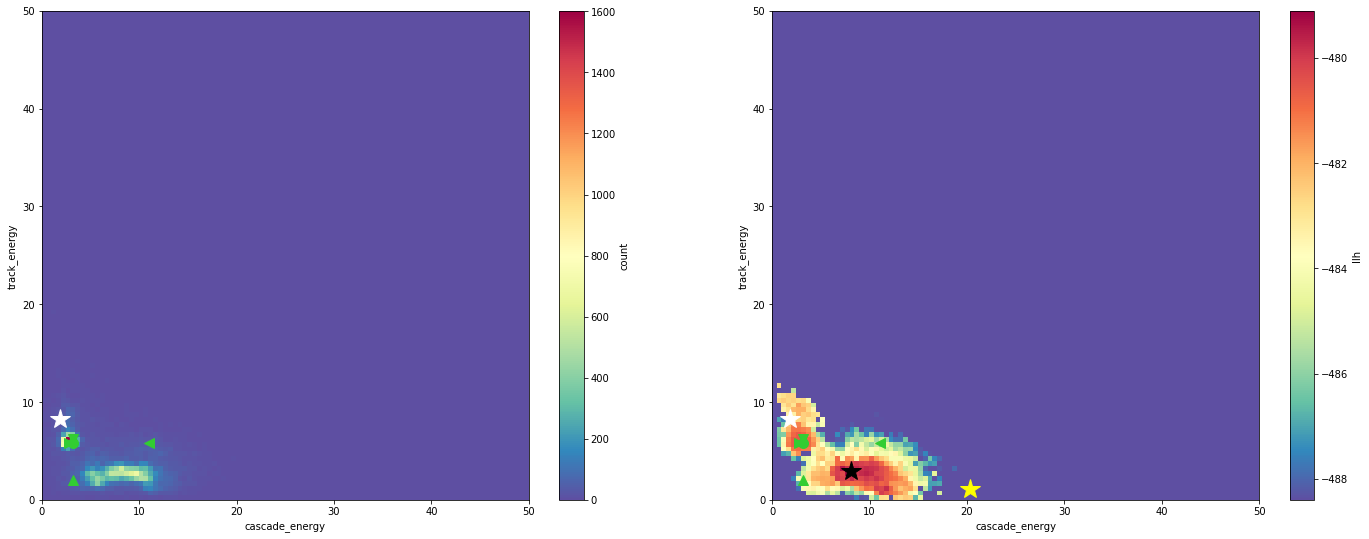

In [2728]:
fig, axes = plt.subplots(figsize=(24, 9), ncols=2, nrows=1)
key = 'energy'
data[key].plot_map(fig, axes[0], 'count', cmap='Spectral_r', cbar=True)
data[key].plot_map(fig, axes[1], 'llh', cmap='Spectral_r', cbar=True, vmin=np.nanmax(data[key]['llh'])-9.3, vmax=np.nanmax(data[key]['llh']))
#data[key].plot_map(fig, axes[1], 'llh', cmap='Spectral_r', cbar=True, vmin=np.nanmax(data[key]['llh'])-15.5, vmax=np.nanmax(data[key]['llh']))

fig.savefig('llhp.png')
plot_estimator(axes[1], estimator, data[key].grid.vars[0], data[key].grid.vars[1], color='limegreen')
#plot_estimator(axes[1], estimator_nometa, data[key].grid.vars[0], data[key].grid.vars[1], color='b')
plot_estimator(axes[0], estimator, data[key].grid.vars[0], data[key].grid.vars[1], color='limegreen')
#plot_estimator(axes[0], estimator_nometa, data[key].grid.vars[0], data[key].grid.vars[1], color='b', est_var='median')
axes[0].plot(truth[data[key].grid.vars[0]], truth[data[key].grid.vars[1]], ms=20, marker='*', color='w')
axes[1].plot(truth[data[key].grid.vars[0]], truth[data[key].grid.vars[1]], ms=20, marker='*', color='w')
axes[1].plot(pegleg[data[key].grid.vars[0]], pegleg[data[key].grid.vars[1]], ms=20, marker='*', color='yellow')
axes[1].plot(llhp[np.argmax(llhp['llh'])][data[key].grid.vars[0]], llhp[np.argmax(llhp['llh'])][data[key].grid.vars[1]], ms=20, marker='*', color='k')

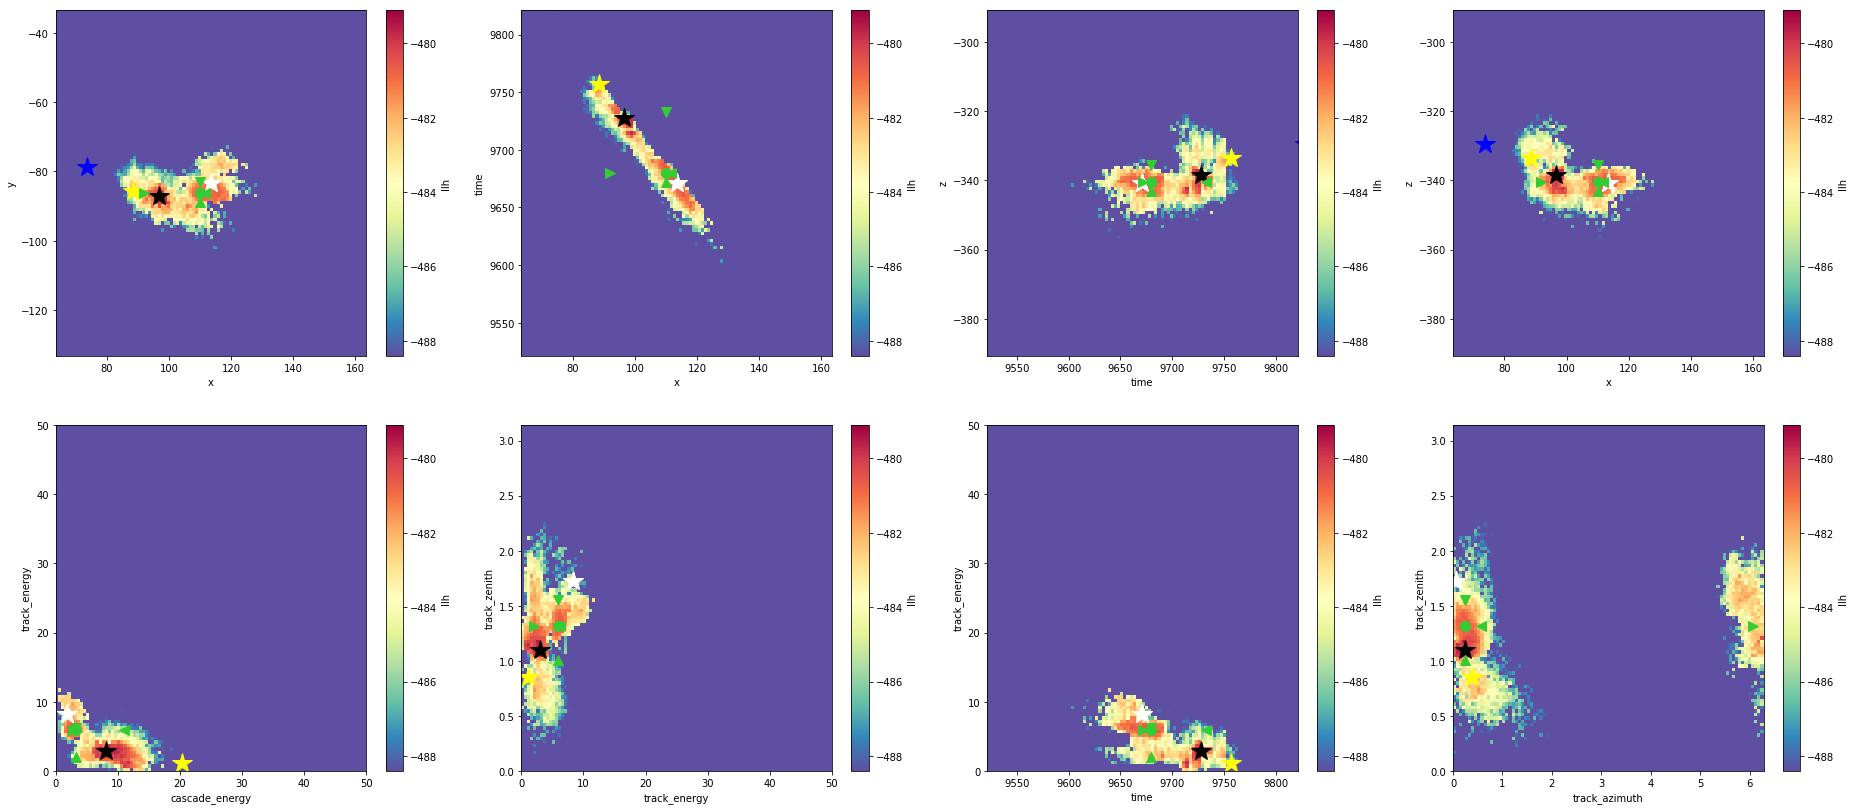

In [2729]:
fig, axes = plt.subplots(figsize=(32, 14), ncols=4, nrows=2)
plot(fig, axes[0,0], 'xy', data, estimator, truth, spe)
plot(fig, axes[0,1], 'xt', data, estimator, truth, spe)
plot(fig, axes[0,2], 'tz', data, estimator, truth, spe)
plot(fig, axes[0,3], 'xz', data, estimator, truth, spe)
plot(fig, axes[1,0], 'energy', data, estimator, truth, spe)
plot(fig, axes[1,1], 'ezen', data, estimator, truth, spe)
plot(fig, axes[1,2], 'ten', data, estimator, truth, spe)
plot(fig, axes[1,3], 'azzen', data, estimator, truth, spe)
#fig.savefig('before.png')

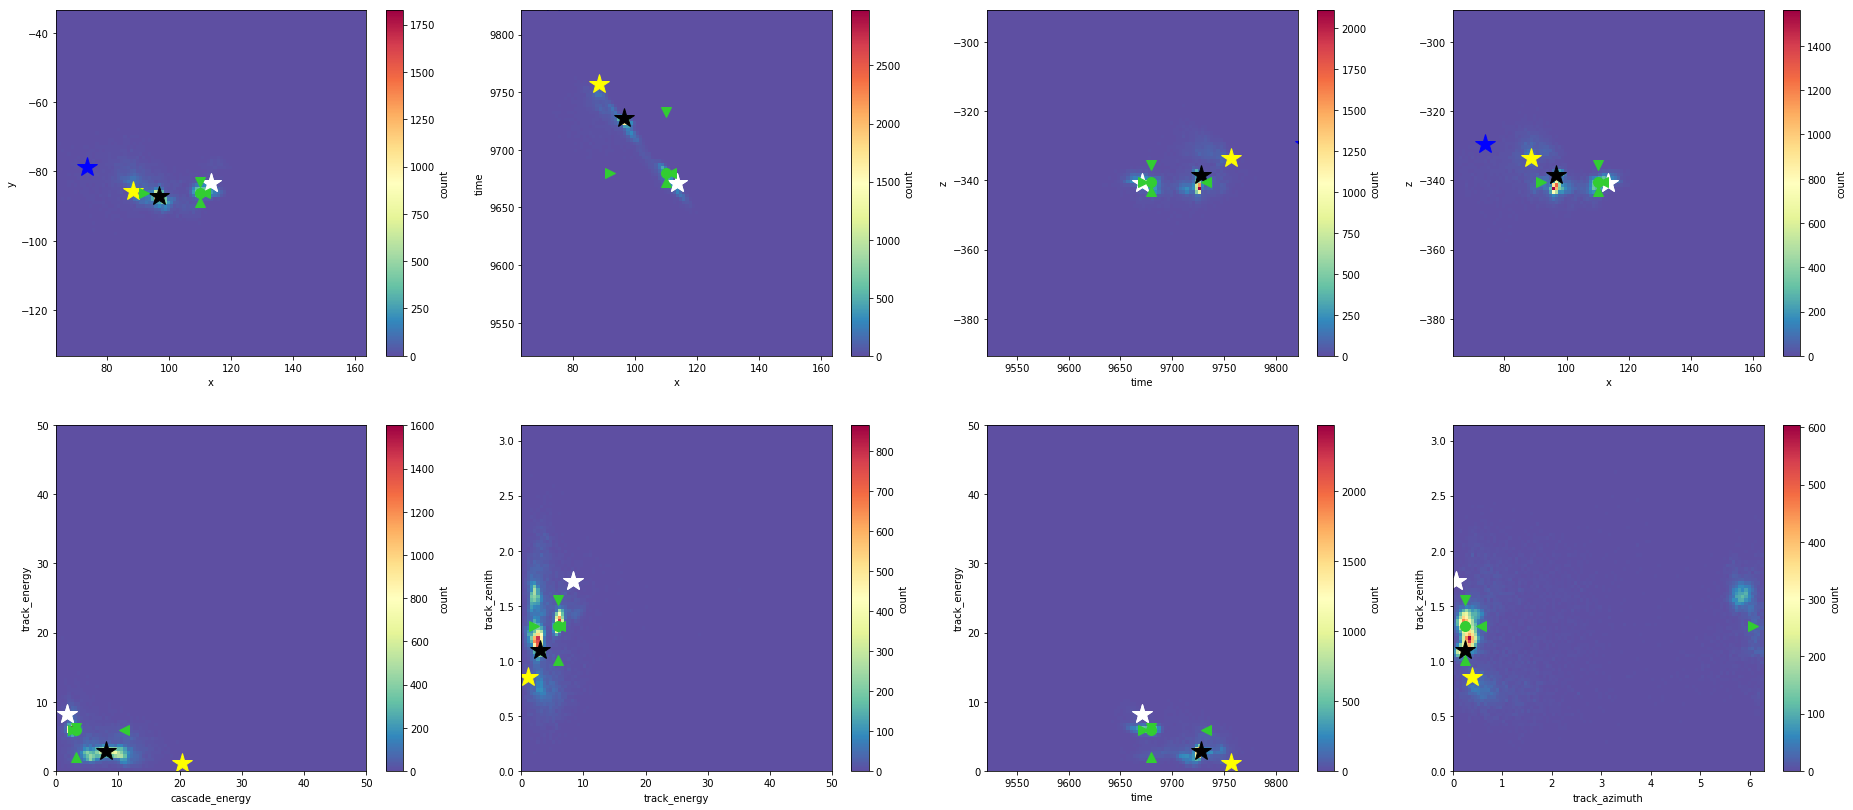

In [2730]:
fig, axes = plt.subplots(figsize=(32, 14), ncols=4, nrows=2)
plot(fig, axes[0,0], 'xy', data, estimator, truth, spe, var='count')
plot(fig, axes[0,1], 'xt', data, estimator, truth, spe, var='count')
plot(fig, axes[0,2], 'tz', data, estimator, truth, spe, var='count')
plot(fig, axes[0,3], 'xz', data, estimator, truth, spe, var='count')
plot(fig, axes[1,0], 'energy', data, estimator, truth, spe, var='count')
plot(fig, axes[1,1], 'ezen', data, estimator, truth, spe, var='count')
plot(fig, axes[1,2], 'ten', data, estimator, truth, spe, var='count')
plot(fig, axes[1,3], 'azzen', data, estimator, truth, spe, var='count')
#fig.savefig('before.png')

In [2390]:
np.argmax(llhp['llh'])

5796

In [2391]:
len(llhp.data)

15303

In [1993]:
chi2 = stats.chi2.sf(-2*(llhp['llh'] - np.max(llhp['llh'])), 1)

In [1994]:
chi2

array([6.90174972e-47, 5.52916145e-40, 8.93200444e-66, ...,
       5.06709232e-10, 3.25261339e-08, 1.29984614e-05])

In [2018]:
llhp[np.argmax(llhp['llh'])]

(-907.95575, 9786.155, 94.10807, 33.126106, -390.41876, 2.6409802, 4.004354, 9.954413, 12.987333)

In [2389]:
llhp.data[-1]

(-807.24225, 9714.395, 40.495907, -76.6322, -357.54385, 0.9174522, 4.4671626, 12.836641, 24.595581)

In [2388]:
sorted(-llhp['llh'])

[614.733,
 652.10065,
 670.44385,
 685.61017,
 690.2095,
 693.94965,
 698.56635,
 702.70355,
 705.6112,
 710.51654,
 716.04553,
 719.2287,
 723.7869,
 725.12646,
 726.0668,
 727.6164,
 727.71045,
 727.73096,
 727.8562,
 727.9626,
 729.00073,
 729.6996,
 730.8638,
 733.00024,
 733.4052,
 734.15393,
 735.68695,
 736.41754,
 736.5626,
 737.29425,
 739.19666,
 742.2484,
 743.5815,
 744.12494,
 744.15,
 744.179,
 744.8964,
 744.9439,
 745.2569,
 745.48486,
 746.8734,
 747.38007,
 747.8216,
 750.3414,
 750.37823,
 750.5787,
 751.71716,
 752.49945,
 753.17377,
 753.7117,
 753.8034,
 753.98553,
 754.33636,
 754.9055,
 755.181,
 755.4604,
 755.7374,
 755.9135,
 755.93567,
 756.053,
 756.12445,
 756.32904,
 757.40857,
 757.7528,
 758.17053,
 758.56573,
 759.1854,
 759.25,
 759.3665,
 760.50476,
 760.56464,
 760.5878,
 762.1346,
 762.1775,
 762.2857,
 762.3161,
 762.3443,
 762.85876,
 763.0112,
 763.0886,
 763.2033,
 763.34796,
 763.49384,
 763.52997,
 763.5651,
 763.81213,
 764.67334,
 764.9628,

In [2054]:
np.average(llhp['track_zenith'][llhp['llh'] > - 920])

1.8308367

In [1999]:
np.exp((llhp['llh'] - np.max(llhp['llh']))[llhp['llh'] > - 430])**(1./8)

array([], dtype=float32)

In [2000]:
llhp['llh']


array([-646.6995 , -630.8853 , -690.0172 , ..., -562.63184, -558.58154,
       -552.8116 ], dtype=float32)

In [2053]:
np.max(llhp['track_zenith'])

3.1247323

In [2320]:
l = range(10)

In [2326]:
l[0:9]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [2339]:
e = np.empty(shape=10, dtype=dtype)

In [2330]:
dtype = np.dtype([('a',np.float32), ('b',np.int)])

In [2341]:
e['b'] = 1

In [2338]:
for a in e: print a

In [2342]:
e

array([(-765.9519 , 1), (-673.13245, 1), (-607.6552 , 1), (-604.46216, 1),
       (-592.2487 , 1), (-721.2773 , 1), (-600.5176 , 1), (-681.5389 , 1),
       (-607.9268 , 1), (-585.28516, 1)],
      dtype=[('a', '<f4'), ('b', '<i8')])